## 模型训练

- 数据集切分按照疾病、种族进行

- 目前只针对蛋白组

- 分种族训练



### 预处理

In [3]:
from config import *
import pandas as pd
import json
from ppp_prediction.utils import load_data
from ppp_prediction.model import fit_best_model
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from ppp_prediction.plot.utils import save_fig

/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2025-02-19 20:13:14,563	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-19 20:13:14,844	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-19 20:13:14,945	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
# Define Basic Variables

groupByVar = "Ethnic"  # Ethnic
omicsName = "Prot_meanImpute"  # used omics Name
phenoDefineVersion = "Lancet_Digital_Health_2019"  # used pheno version

## cutoff
Case_cutoff = 50  # only over this number of cases will be used as a phenotype

In [5]:
# Define the dirs
covariates_dir = dataDir / "covariates.feather"
omicsDataDir = dataDir / f"Prot/{omicsName}.feather"

phenoDefineDir = dataDir / f"{phenoDefineVersion}"

In [6]:
# load data
covariates_df = pd.read_feather(covariates_dir)
omicsData = pd.read_feather(omicsDataDir)
print(
    f"Total {omicsData.shape[0]} samples and {omicsData.shape[1]} features with {omicsName}"
)
diseaseList = list(phenoDefineDir.glob("*.feather"))
foundedPhenoFile = len(list(phenoDefineDir.glob("*.feather")))
print(f"Founded Pheno Files: {foundedPhenoFile}")
covariates_df

Total 53021 samples and 2912 features with Prot_meanImpute
Founded Pheno Files: 169


,eid,sex,height,weight,BSA,age,PC1,PC2,PC3,PC4,...,drug_ldl,drug_hdl,drug_tc,drug_sbp,drug_dbp,genotype_array,assessment_center,ancestry,ancestry_high_confi,Ethnic
0,1000017,1.0,172.0,89.5,2.067876,56.0,-11.3690,3.56718,-1.975530,0.213937,...,0.0,0.0,0.0,1.0,1.0,1,1,EUR,EUR,White
1,1000025,1.0,176.0,113.9,2.359755,62.0,-12.1620,2.77470,0.175048,2.554930,...,1.0,0.0,1.0,1.0,1.0,2,2,EUR,EUR,White
2,1000038,1.0,179.5,112.2,2.365252,60.0,-12.8698,6.41566,-5.106100,-1.296310,...,0.0,0.0,0.0,1.0,1.0,1,3,EUR,EUR,White
3,1000042,1.0,169.0,77.1,1.902476,60.0,72.9437,-109.21600,74.692200,17.863400,...,1.0,0.0,1.0,1.0,1.0,2,3,SAS,SAS,Asian
4,1000056,0.0,163.0,72.0,1.805547,65.0,-10.7174,5.77507,0.620341,0.505251,...,0.0,0.0,0.0,0.0,0.0,2,4,EUR,EUR,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502404,6024086,0.0,154.0,88.0,1.940218,66.0,-11.1845,4.08367,-0.006942,-0.325017,...,0.0,0.0,0.0,0.0,0.0,2,8,EUR,EUR,White
502405,6024098,1.0,173.0,81.3,1.976592,68.0,-13.3426,2.56658,-0.076882,6.048100,...,0.0,1.0,0.0,1.0,1.0,2,9,EUR,EUR,White
502406,6024103,1.0,187.0,111.3,2.404458,61.0,-12.2113,4.22902,-2.629170,4.489250,...,0.0,0.0,0.0,1.0,1.0,2,20,EUR,EUR,White
502407,6024110,1.0,177.0,73.2,1.897103,66.0,-10.5527,6.84118,-2.149580,-0.825010,...,0.0,0.0,0.0,0.0,0.0,2,11,EUR,EUR,White


In [7]:
# groupByVar used
used_groupByVar = ["White", "Asian", "Black"]
covariates_df[groupByVar].value_counts()

Ethnic
White      472610
Asian        9879
Black        8058
Other        7335
Mixed        2954
Chinese      1573
Name: count, dtype: int64

In [6]:
# show all disease rate in Prot


res_dict = {
    "event": [],
    "incident": [],
    "prevalent": [],
}
for disease in tqdm(diseaseList, total=len(diseaseList), desc="Counting..."):
    df = pd.read_feather(disease).query("eid in @omicsData.eid")

    for col in ["event", "incident", "prevalent"]:
        case = int(df[col].sum())
        control = int(df.shape[0] - case)
        rate = case / df.shape[0]
        res_dict[col].append(
            pd.DataFrame(
                {
                    "Phenotype": [disease.stem],
                    "Case": [case],
                    "Control": [control],
                    "Rate": [rate],
                }
            )
        )

Counting...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [01:01<00:00,  2.75it/s]


In [7]:
event_df = (
    pd.concat(res_dict["event"])
    .sort_values("Rate", ascending=False)
    .reset_index(drop=True)
)
incident_df = (
    pd.concat(res_dict["incident"])
    .sort_values("Rate", ascending=False)
    .reset_index(drop=True)
)
prevalent_df = (
    pd.concat(res_dict["prevalent"])
    .sort_values("Rate", ascending=False)
    .reset_index(drop=True)
)

event_df

,Phenotype,Case,Control,Rate
0,hypertension,18096,34925,0.341299
1,oth_organisms,9692,43329,0.182795
2,bacterial,9516,43505,0.179476
3,cataract,7811,45210,0.147319
4,diverticuli,7732,45289,0.145829
...,...,...,...,...
164,HBW,0,53021,0.000000
165,neo_jaundice,0,53021,0.000000
166,sepsis_newborn,0,53021,0.000000
167,prematurity,0,53021,0.000000


/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
/deeplearning/xutingfeng/miniforge3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


(0.0, 0.2)

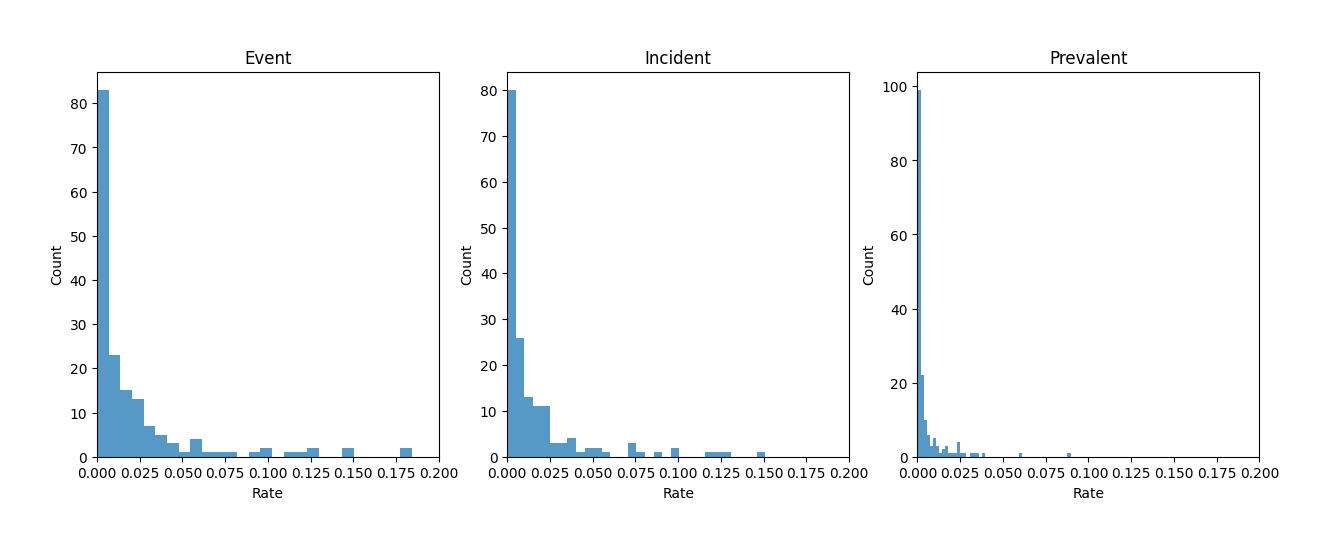

In [8]:
# plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# histplot
sns.histplot(data=event_df, x="Rate", ax=ax1, bins=50)
sns.histplot(data=incident_df, x="Rate", ax=ax2, bins=50)
sns.histplot(data=prevalent_df, x="Rate", ax=ax3, bins=50)

ax1.set_title("Event")
ax2.set_title("Incident")
ax3.set_title("Prevalent")

ax1.set_xlim(0, 0.2)
ax2.set_xlim(0, 0.2)
ax3.set_xlim(0, 0.2)

In [9]:
# event_df =
incident_df = incident_df.query("Case > @Case_cutoff")
prevalent_df = prevalent_df.query("Case > @Case_cutoff")

print(f"Finnal Incident Phenotype: {incident_df.shape[0]}")
print(f"Finnal Prevalent Phenotype: {prevalent_df.shape[0]}")

Finnal Incident Phenotype: 141
Finnal Prevalent Phenotype: 99


### Run Assoc

1. For prevalence, by Cox 
2. For incident, by logit

In [ ]:
# Run Cox

## step1 extract all sample size over 30 and run cox for Prot 


In [ ]:
# incident_df


# cross_corr_v3.py -q /home/xutingfeng/ukb/project/renji/data/phewas/NMR.pkl -k compative_disease.feather --cond /home/xutingfeng/ukb/project/renji/data/cov.feather  --key_cols disease survTime --event_key_cols disease --date_key_cols survTime --comprisk_order control CAD AAA -t 4 --cond_cols age --cat_cond_cols sex assessment_center any_lipids_drug -o test.tsv

# parallel -q echo "cross_corr_v3.py  -q data/phewas/{2}.pkl -k output/02-PSM/PSM_matched_data_1_{3}_{5}_{4}_{1}.feather    --key_cols incident survTime --date_key_cols survTime --event_key_cols incident --cond output/covs.feather --cond_cols age BMI  --cat_cond_cols assessment_center sex any_lipids_drug any_lower_pressure_drug smoking   -o output/01-phewas/PSM_matched_data_1_{3}_{5}_{4}/{1}/{2}.tsv --norm_x zscore " ::: CAD AAA  ::: NMR ::: 2 3 ::: glm ::: nearest |bash

### 过滤表型

保存Case 至少>50的疾病

分种族过滤！

In [11]:
from ppp_prediction.model_v2.models import (
    fit_best_model_v2,
    fit_ensemble_model_simple_v2,
    fit_lightgbm,
    fit_xgboost,
)


def get_predict_v2_from_df(
    model,
    data,
    x_var,
):
    """
    merge by idx
    """

    no_na_data = data[x_var].dropna().copy()
    if hasattr(model, "predict_proba"):
        no_na_data["pred"] = model.predict_proba(no_na_data)[:, 1]
    else:
        no_na_data["pred"] = model.predict(no_na_data)

    return (
        data[[]]
        .merge(no_na_data[["pred"]], left_index=True, right_index=True, how="left")
        .values.flatten()
    )

In [18]:
from sklearn.model_selection import train_test_split
from ppp_prediction.metrics import cal_binary_metrics


# define a function to fit the model, save the result and collect the scores
## parallel this function
def fit_model_and_save_result(
    total_df,  # first col should be eid
    label_df,  # first col should be eid
    save_dir,
    # asssoc_df=None, # used to sort and get top features to downsample, if None then will do assoc
    feature_rank_list=None,  # used to downsample the features
    min_class_number_cutoff={"train": 30, "validation": 10, "test": 10},
    train_test_split_ratio=0.7,
    seed=1234,
    device="cuda",
    topk_list=[5, 10, 20, 50, 100],
):
    """
    1. merge the total_df and disease_df
    2. check label_df sum is over min_class_number_cutoff; if not return None, and print the error
    3. fit the models: 1) full lasso, 2) full xgboost, 3) sample lasso, 4) sample xgboost, 5) sample AutoTabPFN, 6) TabPFN
    4. save the results: 1) model, 2) scores of total_df, 3) metrics of models
    """
    # step1: merge and check

    ## check the first column
    if total_df.columns[0] != "eid":
        raise ValueError("total_df first column should be eid")
    if label_df.columns[0] != "eid":
        raise ValueError("label_df first column should be eid")

    features = total_df.columns[1:].tolist()
    label = label_df.columns[1]

    ## merge
    merged_df = pd.merge(total_df, label_df, on="eid", how="inner")
    print(
        f"Found merged samples: {merged_df.shape[0]} while, label_df: {label_df.shape[0]} and total_df: {total_df.shape[0]}"
    )

    # step2: fit the model
    ## step2.1 Train Test Split
    train_df, test_df = train_test_split(
        merged_df, test_size=1 - train_test_split_ratio, random_state=seed
    )
    train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=seed)

    score_df = pd.concat(
        [
            train_df[["eid", label]].copy().assign(Type="train"),
            val_df[["eid", label]].copy().assign(Type="validation"),
            test_df[["eid", label]].copy().assign(Type="test"),
        ]
    )
    ## step2.2 check the min_class_number
    for min_class_number_check_key in ["train", "validation", "test"]:
        if min_class_number_check_key == "train":
            to_check_df = train_df
        elif min_class_number_check_key == "validation":
            to_check_df = val_df
        elif min_class_number_check_key == "test":
            to_check_df = test_df
        else:
            raise ValueError(
                "min_class_number_check_key should be in ['train', 'validation', 'test']"
            )
        min_class_number = min(to_check_df[label].value_counts())
        # the min class number and class name
        min_class_name = to_check_df[label].value_counts().idxmin()
        if min_class_number < min_class_number_cutoff[min_class_number_check_key]:
            print(
                f"Error: {min_class_number_check_key} {min_class_name} has only {min_class_number} samples, less than {min_class_number_cutoff[min_class_number_check_key]}"
            )
            return None
    print(
        f"Train data have {train_df.shape[0]} samples with {train_df[label].sum():.0f} cases"
    )
    print(
        f"Validation data have {val_df.shape[0]} samples with {val_df[label].sum():.0f} cases"
    )
    print(
        f"Test data have {test_df.shape[0]} samples with {test_df[label].sum():.0f} cases"
    )

    ## check
    train_meta_info = {}
    ## step2.4 fit the models
    modelSaveDir = save_dir / "models"
    modelSaveDir.mkdir(parents=True, exist_ok=True)
    ### 1) Lasso full
    lasso_full_savedir = modelSaveDir / "lasso_full.pkl"
    if lasso_full_savedir.exists():
        lasso_full = pickle.load(open(lasso_full_savedir, "rb"))
        # print(f"lasso_full loaded")

    else:
        lasso_engine = "cuml" if device == "cuda" else "sklearn"
        print(merged_df.shape)
        if merged_df.shape[0] < 5000:
            lasso_engine = "sklearn"
        print(f"lasso_full start with engine {lasso_engine}")
        (lasso_full, *_) = fit_best_model(
            train_df=train_df,
            test_df=val_df,
            X_var=features,
            y_var=label,
            method_list="Lasso",
            cv=5,
            engine=lasso_engine,
        )

        pickle.dump(lasso_full, open(lasso_full_savedir, "wb"))

    score_df["lasso_full"] = get_predict_v2_from_df(lasso_full, total_df, features)
    # return lasso_full, score_df
    train_meta_info[f"lasso_full"] = {
        "train_case": train_df[label].sum(),
        "train_control": train_df.shape[0] - train_df[label].sum(),
    }
    if isinstance(feature_rank_list, str):
        if feature_rank_list == "assoc":
            # feature_rank_list = lasso_full.coef_.argsort()
            raise NotImplementedError("assoc not implemented")
            # pass
        elif feature_rank_list == "lasso":
            feature_rank_df = pd.DataFrame(
                [lasso_full.feature_names_in_, lasso_full[-1].coef_]
            ).T
            feature_rank_df.columns = ["feature", "coef"]
            feature_rank_df["abs_coef"] = feature_rank_df["coef"].abs()
            feature_rank_df = feature_rank_df.sort_values("abs_coef", ascending=False)

            feature_rank_df.to_csv(
                save_dir / "feature_rank_lasso_full.csv", index=False
            )
            feature_rank_list = feature_rank_df.query("abs_coef != 0 ")["feature"].tolist()
        else:
            raise ValueError(
                "feature_rank_list should be in ['assoc', 'lasso'] or a list of features with the first one is the most important"
            )
    elif isinstance(feature_rank_list, list):
        pass
    else:
        raise ValueError(
            "feature_rank_list should be in ['assoc', 'lasso'] or a list of features with the first one is the most important"
        )

    del lasso_full

    # xgboost full
    xgboot_full_savedir = modelSaveDir / "xgboost_full.pkl"
    if (modelSaveDir / "xgboost_full.pkl").exists():
        print(f"xgboost_full loaded")
        xgboost_full_tuned = pickle.load(open(xgboot_full_savedir, "rb"))
    else:

        xgboost_full_tuned, *_ = fit_xgboost(
            train=train_df,
            xvar=features,
            label=label,
            tuning=True,
            tune_config={"max_iter": 100},
        )
        pickle.dump(xgboost_full_tuned, open(xgboot_full_savedir, "wb"))
    score_df["xgboost_full"] = get_predict_v2_from_df(
        xgboost_full_tuned, total_df, features
    )
    train_meta_info[f"xgboost_full"] = {
        "train_case": train_df[label].sum(),
        "train_control": train_df.shape[0] - train_df[label].sum(),
    }

    del xgboost_full_tuned

    for strata in ["balance", 
                   # "random"
                  ]:  # balance or random
        if strata == "balance":
            disease_train_case = train_df.query(f"{label} == 1")
            disease_train_case_number = min(disease_train_case.shape[0], 5000)

            disease_train_case = disease_train_case.sample(
                n = disease_train_case_number , random_state=seed, replace=False
            )
            
            disease_train_control = train_df.query(f"{label} == 0").sample(
                n=disease_train_case.shape[0], random_state=seed
            )
            disease_train_sample = pd.concat(
                [disease_train_case, disease_train_control]
            )
        elif strata == "random":
            if train_df.shape[0] > 10000:
                disease_train_sample = train_df.sample(n=10000, random_state=seed)
            else:
                disease_train_sample = train_df  # TODO: Anno this with no sample

        for topk in topk_list:
            sig_features = feature_rank_list[:topk]

            suffix_name = f"{topk}_{strata}"

            print(suffix_name)

            strata_topk_save_dir = modelSaveDir / f"{topk}/{strata}"
            strata_topk_save_dir.mkdir(parents=True, exist_ok=True)

            X_train = disease_train_sample[sig_features]
            y_train = disease_train_sample[label]

            lasso_sample_topk_savedir = strata_topk_save_dir / f"lasso_sample.pkl"
            if lasso_sample_topk_savedir.exists():
                lasso_sample = pickle.load(open(lasso_sample_topk_savedir, "rb"))
                print(f"lasso_sample_{suffix_name} loaded")
            else:
                try:
                    lasso_engine = "cuml" if device == "cuda" else "sklearn"
                    if X_train.shape[0] < 5000:
                        lasso_engine = "sklearn"
                    print(f"lasso_full start with engine {lasso_engine}")

                    (lasso_sample, *_) = fit_best_model(
                        train_df=disease_train_sample,
                        test_df=val_df,
                        X_var=sig_features,
                        y_var=label,
                        method_list="Lasso",
                        cv=5,
                        engine=lasso_engine,
                    )
                    pickle.dump(
                        lasso_sample,
                        open(strata_topk_save_dir / f"lasso_sample.pkl", "wb"),
                    )
                except Exception as e:
                    print(f"lasso_sample_{topk} failed and erros: {e}")

            score_df[f"lasso_sample_{suffix_name}"] = get_predict_v2_from_df(
                lasso_sample, total_df, sig_features
            )
            train_meta_info[f"lasso_sample_{suffix_name}"] = {
                "train_case": disease_train_sample[label].sum(),
                "train_control": disease_train_sample.shape[0]
                - disease_train_sample[label].sum(),
            }

            del lasso_sample

            from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import (
                AutoTabPFNClassifier,
            )

            AutoTabPFN_topk_savedir = strata_topk_save_dir / f"AutoTabPFN.pkl"
            if AutoTabPFN_topk_savedir.exists():
                AutoTabPFN = pickle.load(open(AutoTabPFN_topk_savedir, "rb"))
                print(f"AutoTabPFN_{topk} loaded")
            else:

                try:
                    AutoTabPFN = AutoTabPFNClassifier(
                        max_time=120, device="cuda" if device == "cuda" else "cpu", ignore_pretraining_limits=True
                    )  # 120 seconds tuning time
                    AutoTabPFN.fit(X_train, y_train)
                    pickle.dump(
                        AutoTabPFN, open(strata_topk_save_dir / f"AutoTabPFN.pkl", "wb")
                    )
                except Exception as e:
                    print(f"AutoTabPFN_{topk} failed with {e}")

            # score_df["AutoTabPFN"] = AutoTabPFN.predict_proba(X_held_out_test)[:, 1]
            score_df[f"AutoTabPFN_{suffix_name}"] = AutoTabPFN.predict_proba(
                total_df[sig_features]
            )[:, 1]
            train_meta_info[f"AutoTabPFN_{suffix_name}"] = {
                "train_case": disease_train_sample[label].sum(),
                "train_control": disease_train_sample.shape[0]
                - disease_train_sample[label].sum(),
            }

            del AutoTabPFN
            try:
                from tabpfn import TabPFNClassifier

                TabPFN_topk_savedir = strata_topk_save_dir / f"TabPFN{topk}.pkl"
                if TabPFN_topk_savedir.exists():
                    TabPFN = pickle.load(open(TabPFN_topk_savedir, "rb"))
                    
                    print(f"TabPFN_{topk} loaded")
                else:

                    TabPFN = TabPFNClassifier(
                        device="cuda:0" if device == "cuda" else "cpu",
                        ignore_pretraining_limits=True,
                    )
                    TabPFN.fit(X_train, y_train)
                    pickle.dump(
                        TabPFN, open(strata_topk_save_dir / f"TabPFN.pkl", "wb")
                    )
                    # score_df["AutoTabPFN"] = AutoTabPFN.predict_proba(X_held_out_test)[:, 1]
                    score_df[f"TabPFN_{suffix_name}"] = TabPFN.predict_proba(
                        total_df[sig_features]
                    )[:, 1]
                train_meta_info[f"TabPFN_{suffix_name}"] = {
                    "train_case": disease_train_sample[label].sum(),
                    "train_control": disease_train_sample.shape[0]
                    - disease_train_sample[label].sum(),
                }
                del TabPFN
            except Exception as e:
                print(f"TabPFN {topk} failed with {e}")

            # xgboost sampled
            xgboost_sample_savedir = strata_topk_save_dir / f"xgboost_sample.pkl"
            if xgboost_sample_savedir.exists():
                xgboost_sample_tuned = pickle.load(open(xgboost_sample_savedir, "rb"))
                print(f"xgboost_sample_{topk} loaded")
            else:
                try:
                    xgboost_sample_tuned, *_ = fit_xgboost(
                        train=disease_train_sample,
                        xvar=sig_features,
                        label=label,
                        tuning=True,
                        tune_config={"max_iter": 100},
                    )
                    pickle.dump(
                        xgboost_sample_tuned,
                        open(strata_topk_save_dir / f"xgboost_sample.pkl", "wb"),
                    )
                except Exception as e:
                    print(f"xgboost_sample_{topk} failed")

            score_df[f"xgboost_sample_{suffix_name}"] = get_predict_v2_from_df(
                xgboost_sample_tuned, total_df, sig_features
            )
            train_meta_info[f"xgboost_sample_{suffix_name}"] = {
                "train_case": disease_train_sample[label].sum(),
                "train_control": disease_train_sample.shape[0]
                - disease_train_sample[label].sum(),
            }

            del xgboost_sample_tuned

    score_df.to_feather(save_dir / "held_out_test.feather")
    pickle.dump(train_meta_info, open(save_dir / "train_meta_info.pkl", "wb"))
    metrics_list = []
    for key in score_df.columns[3:]:  # eid label Type
        to_cal_df = (
            score_df.query("Type == 'test'")[["eid", label, key]].copy().dropna()
        )
        res = cal_binary_metrics(
            to_cal_df[label], to_cal_df[key], n_resamples=30, ci=True
        )
        # res = run_cox(to_cal_df, var=key, E=E, T=T, ci=True, n_resamples=100)
        res["method"] = key
        res.update(train_meta_info[key])
        metrics_list.append(res)
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df.to_csv(save_dir / "metrics.csv", index=False)

In [19]:
resultDir = outputDir / "test"

In [20]:
%%time 
# for disease in diseaseList:
for disease in [Path("V1/data/Lancet_Digital_Health_2019/hypertension.feather")]:
    diseaseName = disease.stem
    # for c_groupbyVar in used_groupByVar:
    for c_groupbyVar in ["White"]:
        # for label in ["prevalent", "incident"]:
        c_groupbyVar_eids = covariates_df.query(f"{groupByVar} == @c_groupbyVar").eid
        for label in ["incident", "prevalent"]:
            print(f"Currently, Running {label} {diseaseName} and {c_groupbyVar}")
            label_df = pd.read_feather(disease).query("eid in @omicsData.eid")
            res = fit_model_and_save_result(
                total_df=omicsData.query(f"eid in @c_groupbyVar_eids"),
                label_df=label_df[["eid", label]],
                save_dir=resultDir / f"{diseaseName}/{c_groupbyVar}/{label}",
                feature_rank_list="lasso",  # currently use the fake rank list, better use assoc on whole set or run assoc on the train set
                device="cuda",
                topk_list=[5, 10],
            )
            break
        break
    break

Currently, Running incident hypertension and White
Found merged samples: 49442 while, label_df: 53021 and total_df: 49442


KeyboardInterrupt: 

In [ ]:
res[2]

In [15]:
score_df = pd.read_feather("V1/output/test/hypertension/White/incident/held_out_test.feather")
metrics_list = []
for key in score_df.columns[3:]:
    to_cal_df = score_df.query("Type == 'test'")[["eid", label, key]].copy().dropna()
    res = cal_binary_metrics(
        to_cal_df[label], to_cal_df[key], n_resamples=30, ci=True
    )
    # res = run_cox(to_cal_df, var=key, E=E, T=T, ci=True, n_resamples=100)
    res["method"] = key
    metrics_list.append(res)

In [16]:
score_df

,eid,incident,Type,lasso_full,xgboost_full,lasso_sample_5_balance,AutoTabPFN_5_balance,TabPFN_5_balance,xgboost_sample_5_balance,lasso_sample_10_balance,AutoTabPFN_10_balance,TabPFN_10_balance,xgboost_sample_10_balance,lasso_sample_20_balance,AutoTabPFN_20_balance,TabPFN_20_balance,xgboost_sample_20_balance
36467,4717858,1,train,0.022516,0.160115,0.255544,0.185411,0.195054,0.357783,0.177245,0.100927,0.114464,0.494885,0.184815,0.154265,0.133417,0.498293
40639,5140388,0,train,0.217908,0.188215,0.402142,0.381195,0.386042,0.378526,0.289071,0.263934,0.267943,0.495328,0.322815,0.323159,0.301022,0.499192
35369,4607813,1,train,0.118593,0.162985,0.379269,0.333229,0.330958,0.393262,0.272855,0.209982,0.196092,0.494091,0.251587,0.156563,0.158057,0.498014
21917,3215162,1,train,-0.004587,0.188474,0.336355,0.281780,0.283694,0.377587,0.260952,0.179053,0.179263,0.493425,0.185442,0.152709,0.144786,0.498030
14736,2483295,1,train,0.337454,0.292529,0.407918,0.408023,0.401048,0.458739,0.417146,0.341036,0.343110,0.499990,0.545243,0.509983,0.510270,0.500417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26692,3723705,1,test,0.467860,0.341653,0.656962,0.685844,0.689476,0.572780,0.706430,0.749034,0.762235,0.501271,0.664229,0.720228,0.714066,0.501846
44574,5528979,0,test,0.263110,0.374805,0.421220,0.435431,0.438286,0.533529,0.510978,0.711149,0.711054,0.502870,0.433884,0.657809,0.653734,0.502494
48845,5967237,0,test,-0.034537,0.157668,0.200637,0.144268,0.146035,0.307546,0.174320,0.113595,0.115423,0.493637,0.203988,0.128150,0.132470,0.498159
24144,3455574,0,test,0.405940,0.352367,0.726913,0.688602,0.688561,0.574733,0.746596,0.639348,0.641678,0.502956,0.700807,0.651314,0.648113,0.500958


In [17]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df

,AUC,AUC_UCI,AUC_LCI,ACC,ACC_UCI,ACC_LCI,Macro_F1,Macro_F1_UCI,Macro_F1_LCI,Sensitivity,...,Specificity,Specificity_UCI,Specificity_LCI,APR,APR_UCI,APR_LCI,N,N_case,N_control,method
0,0.490933,0.499805,0.478778,0.705521,0.711436,0.697701,0.487309,0.493444,0.480732,0.106285,...,0.905177,0.908005,0.900284,0.248384,0.261198,0.239987,14833,3707,11126,lasso_full
1,0.491894,0.500239,0.480308,0.689881,0.695193,0.683933,0.488936,0.496889,0.483489,0.125708,...,0.877854,0.884906,0.874051,0.246601,0.255733,0.236508,14833,3707,11126,xgboost_full
2,0.495396,0.503295,0.486836,0.589227,0.594605,0.582876,0.500898,0.508388,0.496095,0.337200,...,0.673198,0.681983,0.666645,0.248695,0.259715,0.241147,14833,3707,11126,lasso_sample_5_balance
3,0.496205,0.506790,0.486198,0.607699,0.615133,0.605565,0.504705,0.516875,0.494315,0.303480,...,0.709060,0.713843,0.702477,0.248550,0.257096,0.241306,14833,3707,11126,AutoTabPFN_5_balance
4,0.496093,0.502746,0.484911,0.620441,0.628366,0.611233,0.505679,0.511103,0.499981,0.277313,...,0.734765,0.743655,0.728616,0.248593,0.255428,0.241605,14833,3707,11126,TabPFN_5_balance
5,0.498294,0.507644,0.485639,0.600283,0.607704,0.593708,0.503240,0.507140,0.498043,0.316698,...,0.694769,0.703280,0.685998,0.251462,0.263478,0.242307,14833,3707,11126,xgboost_sample_5_balance
6,0.493710,0.504085,0.488078,0.553024,0.559012,0.544962,0.489483,0.496544,0.481570,0.400593,...,0.603811,0.612860,0.593787,0.247117,0.256430,0.237820,14833,3707,11126,lasso_sample_10_balance
7,0.492480,0.499814,0.483255,0.705589,0.712491,0.696772,0.484978,0.491905,0.478579,0.102239,...,0.906615,0.911377,0.902121,0.248691,0.254699,0.241629,14833,3707,11126,AutoTabPFN_10_balance
8,0.493214,0.501598,0.482873,0.711454,0.716315,0.705501,0.481428,0.486026,0.476413,0.090909,...,0.918210,0.921691,0.913196,0.249337,0.259614,0.240574,14833,3707,11126,TabPFN_10_balance
9,0.493374,0.502250,0.481466,0.741118,0.747494,0.735600,0.448679,0.454376,0.443467,0.025627,...,0.979507,0.981740,0.977407,0.248951,0.254278,0.238021,14833,3707,11126,xgboost_sample_10_balance


In [ ]:
pd.DataFrame([model.feature_names_in_, model[-1].coef_]).T